In [240]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torch.nn.functional as F
import numpy as np
import pandas as pd
import math as math
import matplotlib.pyplot as plt
import os

In [241]:
# Data Loading
DATA_PATH = "data/"
TRAIN_TEST_SPLIT = (0.9, 0.1)

# Data & Augmentation
NUM_CLASSES = 3

# Model 
MODEL_VERSION = "v1"

# Training
BATCH_SIZE = 10
NUM_EPOCHS = 200
PATIENCE = 200
LEARNING_RATE = 3e-4

# Model 
MODEL_VERSION = "v1"

# Saving/Loading Model + Testing
MODEL_PATH = "model/"
MODEL_SAVE_PATH = MODEL_PATH + MODEL_VERSION + "/"
MODEL_NAME = "model.pt"

In [242]:
os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

In [243]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

Using device cpu


In [244]:
class HandDataset(Dataset):
    
    def __init__(self, subset=None):
        self.subset = subset

        if (not self.subset):
            self.file_list = os.listdir(DATA_PATH)
    
    def __getitem__(self, index):

        if(self.subset):
            data, label = self.subset[index]
        else:
             data = torch.from_numpy(np.load(f"{DATA_PATH}{self.file_list[index]}")).to(torch.float32)
             label = F.one_hot(torch.tensor(int(self.file_list[index].split("_")[0])-1), num_classes=NUM_CLASSES).to(torch.float32)
            
        return (data, label)
    
    def __len__(self):
        
        if(self.subset):
            return len(self.subset)
        else: 
            return len(self.file_list)
    

In [245]:
class NeuralNet(nn.Module):
    def __init__(self, num_classes):
        super(NeuralNet, self).__init__()
        self.num_classes = num_classes
        self.fc1 = nn.Linear(63, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, self.num_classes)
        self.batch_norm1 = nn.BatchNorm1d(1024)
        self.batch_norm2 = nn.BatchNorm1d(512)
        self.batch_norm3 = nn.BatchNorm1d(256)
        self.batch_norm4 = nn.BatchNorm1d(128)
        self.batch_norm5 = nn.BatchNorm1d(64)

    
    def forward(self, x):
        out = x
        out = F.relu(self.batch_norm1(self.fc1(out)))
        out = F.relu(self.batch_norm2(self.fc2(out)))
        out = F.relu(self.batch_norm3(self.fc3(out)))
        out = F.relu(self.batch_norm4(self.fc4(out)))
        out = F.relu(self.batch_norm5(self.fc5(out)))
        out = F.relu(self.fc6(out))
        out = F.softmax(out)
        return out

In [246]:


all_set = HandDataset(subset=None)
train_split_set, val_split_set = random_split(all_set, [int(len(all_set) * TRAIN_TEST_SPLIT[0]), int(len(all_set) * TRAIN_TEST_SPLIT[1])])

train_set = HandDataset(subset=train_split_set)
val_set = HandDataset(subset=val_split_set)

In [247]:
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=BATCH_SIZE, shuffle=False)

train_iter = iter(train_loader)
samples, labels = next(train_iter)
print(samples.shape)
print(labels.shape)

torch.Size([10, 63])
torch.Size([10, 3])


In [248]:
model = NeuralNet(NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
n_total_batches = len(train_loader)
n_total_val_batches = len(val_loader)
epoch_avg_train_loss_list = []
epoch_avg_val_acc_list = []
curr_avg_val_acc = 0
patience = 0

for epoch in range(NUM_EPOCHS):
    model.eval()
    new_avg_val_acc = 0
    total_correct = 0
    
    with torch.no_grad():

        for i, (samples, labels) in enumerate(val_loader):
            samples = samples.to(device)
            outputs = model(samples)
            predicted_digits = torch.max(outputs, 1).indices
            actual_digits = torch.max(labels, 1).indices
            total_correct += (predicted_digits == actual_digits).sum().item()
    new_avg_val_acc = total_correct / (n_total_val_batches * BATCH_SIZE)
    epoch_avg_val_acc_list.append(new_avg_val_acc)

    if (new_avg_val_acc >= curr_avg_val_acc or patience < PATIENCE):

        if (new_avg_val_acc >= curr_avg_val_acc):
            patience = 0
            curr_avg_val_acc = new_avg_val_acc
            torch.save(model.state_dict(), MODEL_SAVE_PATH + MODEL_NAME)
        else:
            patience += 1
    else:
        
        if (patience >= PATIENCE):
            break

    model.train()
    epoch_avg_train_loss = 0

    for i, (samples, labels) in enumerate(train_loader):
        samples = samples.to(device)
        outputs = model(samples)
        loss = criterion(outputs, labels)
        epoch_avg_train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    epoch_avg_train_loss = epoch_avg_train_loss / n_total_batches
    epoch_avg_train_loss_list.append(epoch_avg_train_loss)
    print(f'Epoch {epoch+1}, Average Training Loss: {epoch_avg_train_loss:.4f}, Average Validation Accuracy: {new_avg_val_acc:.4f}')




/var/folders/5j/9p8r1p154_g94qd6s6m4z2900000gn/T/ipykernel_69475/4123097913.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(out)


Epoch 1, Average Training Loss: 1.0135, Average Validation Accuracy: 0.1000
Epoch 2, Average Training Loss: 0.9225, Average Validation Accuracy: 0.1000
Epoch 3, Average Training Loss: 0.8765, Average Validation Accuracy: 0.6000
Epoch 4, Average Training Loss: 0.8260, Average Validation Accuracy: 0.3000
Epoch 5, Average Training Loss: 0.8228, Average Validation Accuracy: 0.3000
Epoch 6, Average Training Loss: 0.7955, Average Validation Accuracy: 0.3000
Epoch 7, Average Training Loss: 0.7519, Average Validation Accuracy: 0.3000
Epoch 8, Average Training Loss: 0.7442, Average Validation Accuracy: 0.5000
Epoch 9, Average Training Loss: 0.7487, Average Validation Accuracy: 0.5000
Epoch 10, Average Training Loss: 0.7286, Average Validation Accuracy: 0.6000
Epoch 11, Average Training Loss: 0.7788, Average Validation Accuracy: 0.6000
Epoch 12, Average Training Loss: 0.7320, Average Validation Accuracy: 0.6000
Epoch 13, Average Training Loss: 0.7308, Average Validation Accuracy: 0.6000
Epoch 14

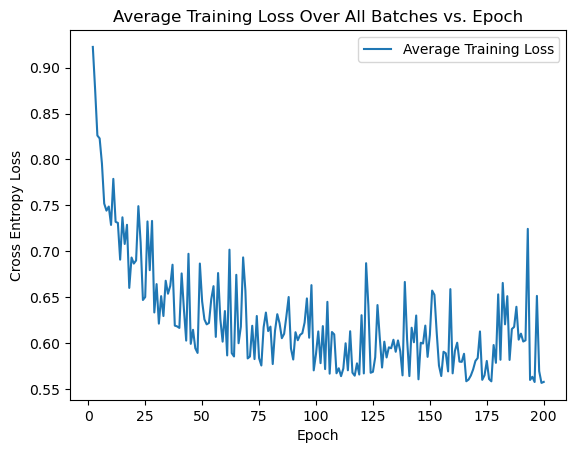

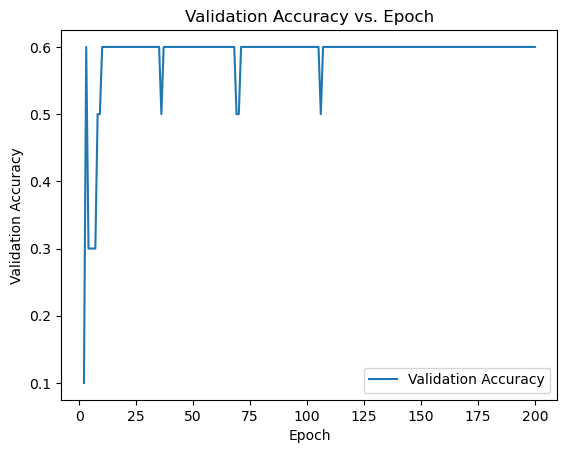

In [249]:
plt.figure()
plt.title("Average Training Loss Over All Batches vs. Epoch")
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epoch")
plt.plot([i+1 for i in range(len(epoch_avg_train_loss_list))][1:], epoch_avg_train_loss_list[1:], label="Average Training Loss")
plt.legend()
plt.show()

plt.figure()
plt.title("Validation Accuracy vs. Epoch")
plt.ylabel("Validation Accuracy")
plt.xlabel("Epoch")
plt.plot([i+1 for i in range(len(epoch_avg_val_acc_list))][1:], epoch_avg_val_acc_list[1:], label="Validation Accuracy")
plt.legend()
plt.show()